## Direct Optimization + A* sampling for TSP 

In [1]:
import os
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
import string
%matplotlib inline

In [2]:
from utils import load_model
import dirpg
from a_star_sampling import Node, Trajectory



In [3]:

class opts:
    def __init__(self,
                 max_interactions=60,
                 alpha=1.0,
                 epsilon=2.0,
                 heuristic='mst',
                 independent_gumbel=False,
                 first_improvement=False,
                 dynamic_weighting = True,
                 dfs_like=False,
                 not_prune=True):        
        self.max_interactions = max_interactions
        self.first_improvement = first_improvement
        self.dynamic_weighting = dynamic_weighting
        self.independent_gumbel = independent_gumbel
        self.heuristic = heuristic
        self.dfs_like = dfs_like
        self.not_prune = not_prune
        self.alpha=alpha
        self.epsilon = epsilon

dirpg_opts = opts()
num_cities = 8
model, _ = load_model('outputs/tsp_{}/jupyter_example/DirPG_20200506T134440/'.format(num_cities), epoch = 0) # 'pretrained/tsp_100/')
#model, _ = load_model('outputs/tsp_{}/visuals/DirPG_20200421T162602/'.format(num_cities), epoch = 1)
#model, _ = load_model('outputs/tsp_{}/visuals/DirPG_20200423T155014/'.format(num_cities), epoch = 0)
model.eval()  # Put in evaluation mode to not track gradients
dirpg = dirpg.DirPG(model, dirpg_opts)

  [*] Loading model from outputs/tsp_8/jupyter_example/DirPG_20200506T134440/epoch-0.pt


In [10]:
import heapq
from utils import utils_gumbel
import networkx as nx
import time

class PriorityQueue:
    def __init__(self,
                 init_state,
                 distance_mat,
                 epsilon,
                 search_params,
                 inference=False
                 ):
        self.queue = []
        self.G = nx.Graph()
        
        Node.epsilon = epsilon
        init_state = init_state._replace(first_a=init_state.first_a.squeeze(0),
                                         prev_a=init_state.prev_a.squeeze(0),
                                         visited_=init_state.visited_.squeeze(0),
                                         lengths=init_state.lengths.squeeze(0),
                                         cur_coord=init_state.cur_coord.squeeze(0),
                                         ids=init_state.ids.squeeze(0),
                                         i=init_state.i.squeeze(0))

        special_action = init_state.prev_a.item()
        not_visited = [i for i in range(init_state.loc.size(1)) if i != special_action]
        self.first_coord = init_state.loc[init_state.ids, special_action]
        self.graph_size = distance_mat.shape[1]

        #           global nodes parameters      #
        Node.alpha = search_params['alpha']
        Node.epsilon = epsilon
        Node.dynamic_weighting = search_params['dynamic_weighting']
        Node.heuristic = search_params['heuristic']
        Node.graph_size = self.graph_size
        Node.dist = distance_mat
        
        self.root_node = Node(id=init_state.ids,
                         first_a=init_state.first_a.item(),
                         next_actions=not_visited, # torch.tensor(not_visited),  # number of cities
                         not_visited=not_visited,
                         prefix=[special_action],
                         lengths=0.0,
                         cur_coord=self.first_coord,
                         max_gumbel=utils_gumbel.sample_gumbel(0),
                         t_opt=True)
        self.G.add_node(self.root_node)
        
        heapq.heappush(self.queue, self.root_node)

        if search_params['independent_gumbel']:
            direct_node = copy.copy(self.root_node)
            direct_node.t_opt = False
            heapq.heappush(self.queue, direct_node)
            
        self.current_node = self.root_node
        self.id = init_state.ids.item()

        self.trajectories_list = []
        self.t_opt = None
        self.t_direct = None

        self.prune_count = 0

        self.orig_dist = distance_mat
        self.start_search_direct = False
        self.start_time = float('Inf')
        # self.max_search_time = max_search_time
        self.num_interactions = 0
        self.first_improvement = search_params['first_improvement']
        self.max_interactions = search_params['max_interactions']
        self.dfs_like = search_params['dfs_like']
        self.p = search_params['prune']
        self.dynamic_weighting = search_params['dynamic_weighting']
        self.inference = inference
        self.prune = False
    
        self.lower_bound = -float('Inf')
        
        #######  plotting  #######
        #priority-queue:
        self.labels = {self.root_node : 'root'}
        self.nodes_opt = []
        self.other_nodes = []
        self.ids = 1
        self.direct_node = None
        
        #prefix:
        

    def pop(self):

        if not self.queue:
            print('the queue is empty')
            return 'break'

        parent = heapq.heappop(self.queue)
        self.current_node = parent

        if self.num_interactions >= self.max_interactions:
            print('interactions budget is over')
            return 'break'

        if self.prune and self.lower_bound > parent.upper_bound:
            self.prune_count += 1
            return self.pop()

        # Start the search time count
        if not parent.t_opt and not self.start_search_direct:
            self.start_time = time.time()
            self.start_search_direct = True

        if parent.done:
            return self.set_trajectory(parent)

        return parent

    def set_trajectory(self, node):

        t = Trajectory(actions=node.prefix,
                       gumbel=node.max_gumbel,
                       length=node.lengths - (self.first_coord - node.cur_coord).norm(p=2, dim=-1),
                       objective=node.objective)

        self.trajectories_list.append(t)

        if node.t_opt:
            self.t_opt = t
            self.t_direct = t
            self.direct_node = node
            self.lower_bound = t.objective
            if self.inference:                
                return 'break'
        else:
            if t.objective > self.t_direct.objective:
                # if len(self.trajectories_list) > 2:
                #    print('here: ', len(self.trajectories_list))
                self.t_direct = t
                self.lower_bound = t.objective
                self.direct_node = node
                if self.first_improvement:
                    #print('*****  priority(direct) > priority(opt)   *****')
                    print('first improvement')
                    return 'break'

        if self.queue:
            return self.pop()
        else:
            # print('break')
            print('5')
            return 'break'

    def expand(self, state, logprobs):

        self.num_interactions += 1
        special_action = state.prev_a.item()
        s = time.time()
        not_visited = [i for i in self.current_node.not_visited if i != special_action]
        cur_coord = state.loc[self.current_node.id, special_action]
        length = -(cur_coord - self.current_node.cur_coord).norm(p=2, dim=-1)

        #updated_prefix = self.current_node.prefix + [special_action]

        #dist = np.delete(np.delete(self.orig_dist, self.current_node.prefix[1:], 0), self.current_node.prefix[1:], 1)
        #print('******** orig ******')
        #print(self.orig_dist)
        #print('******** mod ******')
        #print(dist)
        special_child = Node(
            id=self.current_node.id,
            first_a=self.current_node.first_a,
            not_visited=not_visited,
            prefix=self.current_node.prefix + [special_action],
            lengths=self.current_node.lengths + length,
            cur_coord=cur_coord,
            done=len(not_visited) == 0,
            logprob_so_far=self.current_node.logprob_so_far + logprobs[special_action],
            max_gumbel=self.current_node.max_gumbel,
            next_actions=not_visited,
            depth=self.current_node.depth + 1,
            t_opt=self.current_node.t_opt,
            dfs_like=self.dfs_like)
        
        if special_child.t_opt:
            self.nodes_opt.append(special_child)
        else:
            self.other_nodes.append(special_child)
            
        self.G.add_edge(self.current_node, special_child)
        self.labels[special_child] = str(self.ids)
        self.ids+=1
        if self.prune and special_child.upper_bound < self.lower_bound:
            self.prune_count += 1

        else:
            heapq.heappush(self.queue, special_child)

        # Sample the max gumbel for the non-chosen actions and create an "other
        # children" node if there are any alternatives left.

        m = time.time()
        other_actions = [i for i in self.current_node.next_actions if i != special_action]

        assert len(other_actions) == len(self.current_node.next_actions) - 1
        other_children = None
        if other_actions and not self.inference:
            other_max_location = utils_gumbel.logsumexp(logprobs[other_actions])
            other_max_gumbel = utils_gumbel.sample_truncated_gumbel(self.current_node.logprob_so_far + other_max_location,
                                                                    self.current_node.max_gumbel).item()
            other_children = Node(
                id=self.current_node.id,
                first_a=self.current_node.first_a,
                not_visited=self.current_node.not_visited,
                prefix=self.current_node.prefix,
                lengths=self.current_node.lengths,
                cur_coord=self.current_node.cur_coord,
                done=self.current_node.done,
                logprob_so_far=self.current_node.logprob_so_far,
                max_gumbel=other_max_gumbel,
                next_actions=other_actions,
                depth=self.current_node.depth + 1,
                upper_bound=self.current_node.upper_bound,
                t_opt=False,
                dfs_like=False)
            
            self.other_nodes.append(other_children)
            
            self.G.add_edge(self.current_node, other_children)
            self.labels[other_children] = str(self.ids)
            self.ids+=1
            if self.prune and other_children.upper_bound < self.lower_bound:
                self.prune_count += 1
            else:
                heapq.heappush(self.queue, other_children)

        f = time.time()
        sp = m - s
        oth = f - m
        return special_child, other_children



In [11]:
def encode(x, dirpg):
    embeddings = dirpg.encoder(x, only_encoder=True)
    state = dirpg.encoder.problem.make_state(x)
    fixed = dirpg.encoder.precompute(embeddings)
    return state, fixed


x = torch.rand(1, 20, 2)

def init_queue(x, dirpg, epsilon=1.0, alpha=1.0, start_from = 0):
    dirpg.search_params['alpha'] = alpha 
    state, fixed = encode(x, dirpg)
    _, state = dirpg.forward_and_update(state, fixed, first_action=start_from)
    return PriorityQueue(init_state=state[torch.tensor(0)],
                         distance_mat=state.dist[0],
                         epsilon = epsilon,
                         inference=False,
                         search_params=dirpg.search_params), state, fixed


In [12]:
def sample(queue, fixed, state):
    
    while queue:
        parent = queue.pop()
        if parent == 'break':
            return queue

        batch_state = state.stack_state([parent])
        log_p, state = dirpg.forward_and_update(batch_state, fixed)

        queue.expand(state[torch.tensor(0)], log_p[0])
    
queue,state, fixed = init_queue(x, dirpg)
queue = sample(queue, fixed, state)
print(queue.num_interactions)

interactions budget is over
60


## Interactive tree plot

In [13]:
plt.rcParams['figure.figsize'] = [16, 6]

In [14]:
np.random.seed(3)
torch.manual_seed(3)
x = torch.rand(1, num_cities, 2)
#x = torch.load('good_example_8graph')
abc = string.ascii_lowercase[:x.size(1)]

In [15]:
direct, first_direct = None, True
queue,state, fixed = init_queue(x, dirpg, epsilon=2.0, alpha=1.0)

### Press Ctrl+Entr to expand the queue

#### Left: priority queue,   Right: prefix of the current node (yellow node in the left fig)

t_opt: 
['a', 'd', 'f', 'e', 'g', 'h', 'c', 'b']
t_direct: 
['a', 'd', 'f', 'e', 'g', 'h', 'c', 'b']
special child prefix: 
['a', 'e']
depth:  2


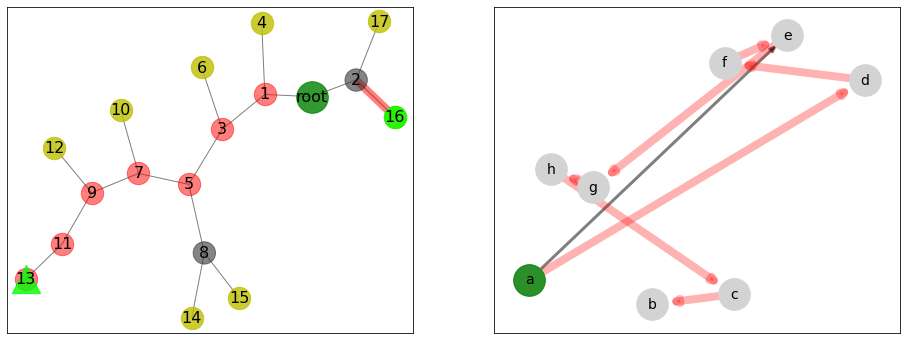

In [24]:
cities = nx.DiGraph()
cities.add_nodes_from(range(x.size(1)))
parent = queue.pop()


if parent == 'break':
    print('END')
else:
    batch_state = state.stack_state([parent])
    log_p, state = dirpg.forward_and_update(batch_state, fixed)

    sp, oth = queue.expand(state[torch.tensor(0)], log_p[0])
    
    if queue.t_opt is not None:
        print('t_opt: ')
        print([abc[i] for i in queue.t_opt.actions])
    if queue.t_direct is not None:
        print('t_direct: ')
        print([abc[i] for i in queue.t_direct.actions])
    print('special child prefix: ')
    print([abc[i] for i in sp.prefix])
    
    
    print('depth: ', sp.depth)
    
    plt.subplot(121)
    pos = nx.kamada_kawai_layout(queue.G)
    # nx.draw_networkx(queue.G,pos=pos, with_labels=False, font_weight='bold')
    colors = []
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=[queue.root_node],                           
                           node_size = 1000,
                           node_color='g',
                           alpha=0.8)
    opt_nodes = [i for i in queue.nodes_opt if i!=sp]
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=opt_nodes,
                           node_size = 500,                           
                           node_color='r',
                           alpha=0.5)
    
    in_queue = [i for i in queue.other_nodes if i in queue.queue]
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=in_queue,
                           node_size = 500,
                           node_color='y',
                           alpha=0.8)
    
    out_of_queue = [i for i in queue.other_nodes if i not in queue.queue]
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=out_of_queue,
                           node_size = 500,
                           node_color=[(0.2,0.2,0.2) for _ in range(len(out_of_queue))],
                           alpha=0.6)    
            
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=[sp],
                           node_size = 500,                           
                           node_color=[(0.0,1.0,0.0)],
                           alpha=0.8)
    """
    if first_direct and queue.t_direct != queue.t_opt:        
        first_direct = False
        direct = queue.t_direct
    """
    if queue.direct_node is not None:
        """
        if direct != queue.t_direct:
            direct = queue.t_direct
         
        """   
        nx.draw_networkx_nodes(queue.G, pos,
                               nodelist=[queue.direct_node],
                               node_shape='^',
                               node_size = 800,                           
                               node_color=[(0.0,1.0,0.0)],
                               alpha=0.8) 

            


    
    nx.draw_networkx_edges(queue.G, pos, width=1.0, alpha=0.5)


    nx.draw_networkx_edges(queue.G, pos,
                           edgelist=[(parent, sp)],
                           width=8, alpha=0.5, edge_color='r')

    
        
    nx.draw_networkx_labels(queue.G, pos, labels= queue.labels, font_size=16)
    
    #####################
    
    plt.subplot(122)
    pos2 = {i:loc.numpy() for i,loc in enumerate(x[0])} 
    edgelist = [(sp.prefix[i],sp.prefix[i+1]) for i in range(len(sp.prefix)) if i<len(sp.prefix)-1]
    
    nx.draw_networkx_nodes(cities, pos2,                            
                           node_size = 1000,
                           node_color='lightgrey',
                           alpha=1.0) 
    
    nx.draw_networkx_nodes(cities, pos2,
                           nodelist=[sp.prefix[0]], 
                           node_size = 1000,
                           node_color='g',
                           alpha=0.8)
    
    nx.draw_networkx_edges(cities, pos2,
                           edgelist=edgelist,
                           width=3, alpha=0.5, min_target_margin=15)
    
    if queue.t_opt is not None:
        a = queue.t_opt.actions
        edgelist = [(a[i],a[i+1]) for i in range(len(a)) if i<len(a)-1]
        nx.draw_networkx_edges(cities, pos2,
                               edgelist=edgelist,
                               width=8, alpha=0.3, edge_color='r',min_target_margin=15)
    
    if queue.t_direct != queue.t_opt:        
        a = queue.t_direct.actions
        edgelist = [(a[i],a[i+1]) for i in range(len(a)) if i<len(a)-1]
        nx.draw_networkx_edges(cities, pos2,
                               edgelist=edgelist,
                               width=8, alpha=0.3, edge_color='g',min_target_margin=15)


    l = {i:abc[i] for i in range(x.size(1))}
    
    nx.draw_networkx_labels(cities, pos2, labels=l, font_size=14)
    last_parent = parent
    
    #nx.draw_networkx(cities,pos, edgelist=edgelist, node_size= 500, node_color='lightgrey' )
    

## Node size: 
##### max Gumbel
## Node color: 
##### epsilon(length + 2MST)

In [25]:
def make_circule(n):
    G = nx.Graph()
    G.add_nodes_from(range(n))
    pos = nx.circular_layout(G, scale=0.5, center=(0.5,0.5))
    
    return torch.tensor([np.stack(list(pos.values()))], dtype = torch.float32)




In [26]:
def min_max_norm(x, a, b):
    min_x = np.min(x)
    max_x = np.max(x)
    return a + (((x - min_x)*(b-a))/(max_x - min_x))

def norm(x):
    return (x-np.mean(x))/np.std(x)

In [27]:
np.random.seed(3)
torch.manual_seed(3)
x = torch.rand(1, num_cities, 2)
# x = make_circule(num_cities)
#x = torch.load('good_example_8graph')


In [28]:
queue,state, fixed = init_queue(x, dirpg, epsilon=20.0, alpha=1.0)
update = False
direct, first_direct = None, True
parent = queue.pop()

t_opt: 
['a', 'd', 'f', 'e', 'g', 'h', 'c', 'b']
t_direct: 
['a', 'd', 'f', 'e', 'g', 'h', 'c', 'b']
special child prefix: 
['a', 'd', 'f', 'e', 'g', 'h', 'b', 'c']
depth:  8
alpha:  1.0


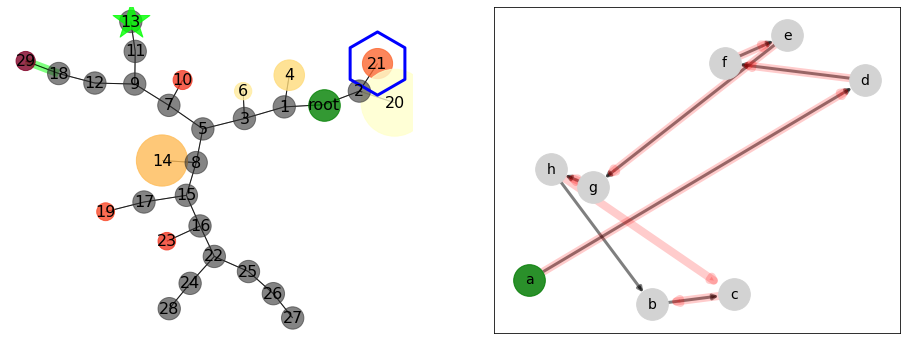

In [64]:
Node.budget = dirpg_opts.max_interactions
update = not update    

cities = nx.DiGraph()
cities.add_nodes_from(range(x.size(1)))
if parent == 'break':
    print('END')
else:
    if update:        
        
        batch_state = state.stack_state([parent])
        log_p, state = dirpg.forward_and_update(batch_state, fixed)

        sp, oth = queue.expand(state[torch.tensor(0)], log_p[0])
    if queue.t_opt is not None:
        print('t_opt: ')
        print([abc[i] for i in queue.t_opt.actions])
    if queue.t_direct is not None:
        print('t_direct: ')
        print([abc[i] for i in queue.t_direct.actions])
        
    print('special child prefix: ')
    print([abc[i] for i in sp.prefix])
    print('depth: ', sp.depth)
    print('alpha: ', sp.alpha)
    ax = plt.subplot(121)
    
    pos = nx.kamada_kawai_layout(queue.G)
    # nx.draw_networkx(queue.G,pos=pos, with_labels=False, font_weight='bold')
    
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=[queue.root_node], 
                           node_size = 1000,
                           node_color='g',
                           alpha=0.8)

    nx.draw_networkx_edges(queue.G, pos, width=1.0, alpha=0.5)


    nx.draw_networkx_edges(queue.G, pos,
                           edgelist=[(parent, sp)],
                           width=8, alpha=0.5, edge_color=(0.0,1.0,0.0))
    """
    print('max_gumbel  +   eps*(- length - 2MST) = ')
    for i,j in zip([n.max_gumbel for n in queue.queue],
                  [Node.epsilon*n.get_upper_bound(2.0).item() for n in queue.queue]):
        
        print(i, ' +  ',j,  '  = ', i+j )
    """
    org_s = [n.max_gumbel for n in queue.queue]
    
    s2 = [300+4000.0*np.exp(n.max_gumbel) for n in queue.queue]
    s_mm = min_max_norm(org_s, a=np.min(org_s) ,b=np.max([5000,np.max(org_s)]))
    s_n = 300+100*norm(org_s)

    colors = [Node.epsilon*n.upper_bound.item() for n in queue.queue]
    nx.draw(queue.G, pos,
        nodelist=queue.queue,
        node_size=s2,
        node_color=colors,
        cmap=plt.cm.YlOrRd,
        alpha=0.8)
    
    out_of_queue = [i for i in queue.G if i not in queue.queue if i != queue.root_node]
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=out_of_queue,
                           node_size = 500,
                           node_color=[(0.2,0.2,0.2) for _ in range(len(out_of_queue))],
                           alpha=0.6) 
    if not update:
        parent = queue.pop()
        ax.set_facecolor(color='none')
        nx.draw_networkx_nodes(queue.G, pos,ax=ax,
                               nodelist=[parent], 
                               node_size = 4000,
                               node_color='none',
                               linewidths=3.0,
                               node_shape = matplotlib.markers.MarkerStyle(marker='h', fillstyle='none'),
                               edgecolors='b')


    
    if queue.direct_node is not None:
        nx.draw_networkx_nodes(queue.G, pos,
                               nodelist=[queue.direct_node],
                               node_shape='*',
                               node_size = 1500,                           
                               node_color=[(0.0,1.0,0.0)],
                               alpha=0.8)
            

    nx.draw_networkx_labels(queue.G, pos, labels= queue.labels, font_size=16)
    
    #####################
    
    plt.subplot(122)
    pos2 = {i:loc.numpy() for i,loc in enumerate(x[0])} 
    edgelist = [(sp.prefix[i],sp.prefix[i+1]) for i in range(len(sp.prefix)) if i<len(sp.prefix)-1]
    
    nx.draw_networkx_nodes(cities, pos2,                            
                           node_size = 1000,
                           node_color='lightgrey',
                           alpha=1.0) 
    
    nx.draw_networkx_nodes(cities, pos2,
                           nodelist=[sp.prefix[0]], 
                           node_size = 1000,
                           node_color='g',
                           alpha=0.8)
    
    nx.draw_networkx_edges(cities, pos2,
                           edgelist=edgelist,
                           width=3, alpha=0.5, min_target_margin=15)
    
    if queue.t_opt is not None:
        a = queue.t_opt.actions
        edgelist = [(a[i],a[i+1]) for i in range(len(a)) if i<len(a)-1]
        nx.draw_networkx_edges(cities, pos2,
                               edgelist=edgelist,
                               width=8, alpha=0.2, edge_color='r',min_target_margin=15)
    
    if queue.t_direct != queue.t_opt:
        a = queue.t_direct.actions
        edgelist = [(a[i],a[i+1]) for i in range(len(a)) if i<len(a)-1]
        nx.draw_networkx_edges(cities, pos2,
                               edgelist=edgelist,
                               width=8, alpha=0.2, edge_color='g',min_target_margin=15)
        
        
        
    l = {i:abc[i] for i in range(x.size(1))}
    
  
    nx.draw_networkx_labels(cities, pos2, labels=l, font_size=14)
    
    

## DFS vs BFS

### DFS: Nodes that extends a prefix are colored orange 
### BFS: Nodes that search for actions other than the last node are colored blue 
### Nodes that explore different prefix are colored yellow 

In [48]:
plt.rcParams['figure.figsize'] = [16, 6]
np.random.seed(4)
torch.manual_seed(4)
x = torch.rand(1, num_cities, 2)
# x = make_circule(num_cities)
#x = torch.load('good_example_8graph')


In [49]:
queue,state, fixed = init_queue(x, dirpg, epsilon=10.0, alpha=5.0)
update = False
direct, first_direct = None, True
dfs, bfs, others = [],[],[]
last_parent = None

t_opt: 
['a', 'e', 'h', 'd', 'g', 'f', 'b', 'c']
t_direct: 
['a', 'e', 'h', 'd', 'g', 'f', 'b', 'c']
special child prefix: 
['a', 'e', 'h', 'd', 'f', 'b']
depth:  8
alpha:  2.25


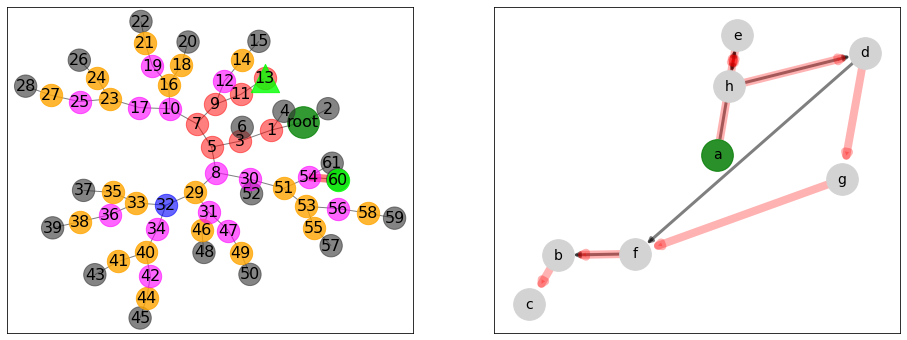

In [91]:
cities = nx.DiGraph()
cities.add_nodes_from(range(x.size(1)))
parent = queue.pop()


if parent == 'break':
    print('END')
else:
    batch_state = state.stack_state([parent])
    log_p, state = dirpg.forward_and_update(batch_state, fixed)

    sp, oth = queue.expand(state[torch.tensor(0)], log_p[0])
    

    if last_parent is not None and parent not in queue.nodes_opt:

        if parent.prefix == last_parent.prefix:
            bfs.append(parent)
        elif parent.prefix[:-1] == last_parent.prefix:
            dfs.append(parent)
        else:
            others.append(parent)
        
    if queue.t_opt is not None:
        print('t_opt: ')
        print([abc[i] for i in queue.t_opt.actions])
    if queue.t_direct is not None:
        print('t_direct: ')
        print([abc[i] for i in queue.t_direct.actions])
    print('special child prefix: ')
    print([abc[i] for i in sp.prefix])
    
    print('depth: ', sp.depth)
    print('alpha: ', sp.alpha)
    
    plt.subplot(121)
    pos = nx.kamada_kawai_layout(queue.G)
    # nx.draw_networkx(queue.G,pos=pos, with_labels=False, font_weight='bold')
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=[queue.root_node],                           
                           node_size = 1000,
                           node_color='g',
                           alpha=0.8)
    opt_nodes = [i for i in queue.nodes_opt if i!=sp]
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=queue.nodes_opt,
                           node_size = 500,                           
                           node_color='r',
                           alpha=0.5)
    
    others_nodes = [i for i in queue.other_nodes if i not in dfs+bfs+others]
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=others_nodes,
                           node_size = 500,
                           node_color=[(0.2,0.2,0.2) for _ in range(len(others_nodes))],
                           alpha=0.6) 
    
    if dfs:
        nx.draw_networkx_nodes(queue.G, pos,
                               nodelist=dfs,
                               node_size = 500,
                               node_color='orange',
                               alpha=0.8)
    if bfs:
        nx.draw_networkx_nodes(queue.G, pos,
                               nodelist=bfs,
                               node_size = 500,
                               node_color='blue',
                               alpha=0.6)  
    if others:
        nx.draw_networkx_nodes(queue.G, pos,
                               nodelist=others,
                               node_size = 500,
                               node_color='magenta',
                               alpha=0.6)             
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=[sp],
                           node_size = 500,                           
                           node_color=[(0.0,1.0,0.0)],
                           alpha=0.8)
    """
    if first_direct and queue.t_direct != queue.t_opt:        
        first_direct = False
        direct = queue.t_direct
    """
    if queue.direct_node is not None:
        """
        if direct != queue.t_direct:
            direct = queue.t_direct
         
        """   
        nx.draw_networkx_nodes(queue.G, pos,
                               nodelist=[queue.direct_node],
                               node_shape='^',
                               node_size = 800,                           
                               node_color=[(0.0,1.0,0.0)],
                               alpha=0.8) 

            


    
    nx.draw_networkx_edges(queue.G, pos, width=1.0, alpha=0.5)


    nx.draw_networkx_edges(queue.G, pos,
                           edgelist=[(parent, sp)],
                           width=8, alpha=0.5, edge_color='r')

    
        
    nx.draw_networkx_labels(queue.G, pos, labels= queue.labels, font_size=16)
    
    #####################
    
    plt.subplot(122)
    pos2 = {i:loc.numpy() for i,loc in enumerate(x[0])} 
    edgelist = [(sp.prefix[i],sp.prefix[i+1]) for i in range(len(sp.prefix)) if i<len(sp.prefix)-1]
    
    nx.draw_networkx_nodes(cities, pos2,                            
                           node_size = 1000,
                           node_color='lightgrey',
                           alpha=1.0) 
    
    nx.draw_networkx_nodes(cities, pos2,
                           nodelist=[sp.prefix[0]], 
                           node_size = 1000,
                           node_color='g',
                           alpha=0.8)
    
    nx.draw_networkx_edges(cities, pos2,
                           edgelist=edgelist,
                           width=3, alpha=0.5, min_target_margin=15)
    
    if queue.t_opt is not None:
        a = queue.t_opt.actions
        edgelist = [(a[i],a[i+1]) for i in range(len(a)) if i<len(a)-1]
        nx.draw_networkx_edges(cities, pos2,
                               edgelist=edgelist,
                               width=8, alpha=0.3, edge_color='r',min_target_margin=15)
    
    if queue.t_direct != queue.t_opt:        
        a = queue.t_direct.actions
        edgelist = [(a[i],a[i+1]) for i in range(len(a)) if i<len(a)-1]
        nx.draw_networkx_edges(cities, pos2,
                               edgelist=edgelist,
                               width=8, alpha=0.3, edge_color='g',min_target_margin=15)


    l = {i:abc[i] for i in range(x.size(1))}
    
    nx.draw_networkx_labels(cities, pos2, labels=l, font_size=14)
    last_parent = parent
    
    #nx.draw_networkx(cities,pos, edgelist=edgelist, node_size= 500, node_color='lightgrey' )
    

In [69]:
a = np.array([[0,2,3,1.5, 2.5],[2,0,6,3,4],[3,6,0,8.5,7],[1.5,3,8.5,0,3.5],[2.5,4,7,3.5,0]])
iu1 = np.triu_indices(4,k=1)
print(a)


[[0.  2.  3.  1.5 2.5]
 [2.  0.  6.  3.  4. ]
 [3.  6.  0.  8.5 7. ]
 [1.5 3.  8.5 0.  3.5]
 [2.5 4.  7.  3.5 0. ]]


In [60]:
first_node = 2
prefix = [2,3]
c = a.copy()
c[:,prefix] = np.inf
c[prefix,:] = np.inf
print(c)
a

[[0.  2.  inf inf 2.5]
 [2.  0.  inf inf 4. ]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [2.5 4.  inf inf 0. ]]


array([[0. , 2. , 3. , 1.5, 2.5],
       [2. , 0. , 6. , 3. , 4. ],
       [3. , 6. , 0. , 8.5, 7. ],
       [1.5, 3. , 8.5, 0. , 3.5],
       [2.5, 4. , 7. , 3.5, 0. ]])

In [75]:
def greedy_path(distance_matrix, prefix):
    M = np.inf
    cost = []
    path = []
    dest = prefix[0]
    current = prefix[-1]
    dm_copy = distance_matrix.copy()

    np.fill_diagonal(dm_copy, M)
    dm_copy[:,prefix[:-1]] = M
    dm_copy[prefix[:-1],:] = M

    while np.any(dm_copy != M):
        
        greedy = np.argmin(dm_copy[current])
        cost.append(dm_copy[current][greedy])
        path.append(greedy)
        dm_copy[:,current] = M
        dm_copy[current, :] = M
        current = greedy
        
    cost.append(distance_matrix[path[-1], dest])    
    return np.sum(cost)

print(greedy_path(a, [2,3]))

def prim(distance_matrix, prefix):
    
    

[[0.  2.  3.  1.5 2.5]
 [2.  0.  6.  3.  4. ]
 [3.  6.  0.  8.5 7. ]
 [1.5 3.  8.5 0.  3.5]
 [2.5 4.  7.  3.5 0. ]]
-------------
-------------
[[inf 2.  inf 1.5 2.5]
 [2.  inf inf 3.  4. ]
 [inf inf inf inf inf]
 [1.5 3.  inf inf 3.5]
 [2.5 4.  inf 3.5 inf]]
3
****************
[[inf 2.  inf inf 2.5]
 [2.  inf inf inf 4. ]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [2.5 4.  inf inf inf]]
0
****************
[[inf inf inf inf inf]
 [inf inf inf inf  4.]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf  4. inf inf inf]]
1
****************
[[inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]]
(14.5, [2, 3, 0, 1, 4, 2])


In [140]:
def mst(W):
    """Determine the minimum spanning tree for a set of points represented
    :  by their inter-point distances... ie their 'W'eights
    :Requires:
    :--------
    :  W - edge weights (distance, time) for a set of points. W needs to be
    :      a square array or a np.triu perhaps
    :Returns:
    :-------
    :  pairs - the pair of nodes that form the edges
    """
    
    W = W.copy() 
    if W.shape[0] != W.shape[1]:
        raise ValueError("W needs to be square matrix of edge weights")
    Np = W.shape[0]
    pairs = []
    pnts_seen = [0]  # Add the first point                    
    n_seen = 1
    # exclude self connections by assigning inf to the diagonal
    diag = np.arange(Np)
    W[diag, diag] = np.inf
    # 
    mst_val = 0
    while n_seen != Np: 
        print("******************")
        print(W[pnts_seen])
        new_edge = np.argmin(W[pnts_seen], axis=None)
        print(new_edge)
        
        mst_val += W[pnts_seen].reshape(-1)[new_edge]
        print(W[pnts_seen].reshape(-1)[new_edge])
        new_edge = divmod(new_edge, Np)
        print(new_edge)
        new_edge = [pnts_seen[new_edge[0]], new_edge[1]]
        print(new_edge)
        pairs.append(new_edge)
        pnts_seen.append(new_edge[1])
        W[pnts_seen, new_edge[1]] = np.inf
        W[new_edge[1], pnts_seen] = np.inf
        print(W)
        n_seen += 1
    return mst_val

In [ ]:
def mst(X):
    """X are edge weights of fully connected graph"""
    X = X.clone()
    
    if X.shape[0] != X.shape[1]:
        raise ValueError("X needs to be square matrix of edge weights")
    n_vertices = X.shape[0]
    spanning_edges = []
    
    # initialize with node 0:                                                                                         
    visited_vertices = [0]                                                                                            
    num_visited = 1
    # exclude self connections:
    X.fill_diagonal_(np.inf)
    
    while num_visited != n_vertices:
        new_edge = np.argmin(X[visited_vertices], axis=None)
        # 2d encoding of new_edge from flat, get correct indices                                                      
        new_edge = divmod(new_edge, n_vertices)
        new_edge = [visited_vertices[new_edge[0]], new_edge[1]]                                                       
        # add edge to tree
        spanning_edges.append(new_edge)
        visited_vertices.append(new_edge[1])
        # remove all edges inside current tree
        X[visited_vertices, new_edge[1]] = np.inf
        X[new_edge[1], visited_vertices] = np.inf                                                                     
        num_visited += 1
    return np.vstack(spanning_edges)

In [141]:
a = [[0,2,3,1.5, 2.5],[2,0,6,3,4],[3,6,0,8.5,7],[1.5,3,8.5,0,3.5],[2.5,4,7,3.5,0]]
a = torch.tensor(a, dtype=torch.float).numpy()

print(a)
mst(a)


[[0.  2.  3.  1.5 2.5]
 [2.  0.  6.  3.  4. ]
 [3.  6.  0.  8.5 7. ]
 [1.5 3.  8.5 0.  3.5]
 [2.5 4.  7.  3.5 0. ]]
******************
[[inf 2.  3.  1.5 2.5]]
3
1.5
(0, 3)
[0, 3]
[[inf 2.  3.  inf 2.5]
 [2.  inf 6.  3.  4. ]
 [3.  6.  inf 8.5 7. ]
 [inf 3.  8.5 inf 3.5]
 [2.5 4.  7.  3.5 inf]]
******************
[[inf 2.  3.  inf 2.5]
 [inf 3.  8.5 inf 3.5]]
1
2.0
(0, 1)
[0, 1]
[[inf inf 3.  inf 2.5]
 [inf inf 6.  inf 4. ]
 [3.  6.  inf 8.5 7. ]
 [inf inf 8.5 inf 3.5]
 [2.5 4.  7.  3.5 inf]]
******************
[[inf inf 3.  inf 2.5]
 [inf inf 8.5 inf 3.5]
 [inf inf 6.  inf 4. ]]
4
2.5
(0, 4)
[0, 4]
[[inf inf 3.  inf inf]
 [inf inf 6.  inf inf]
 [3.  6.  inf 8.5 7. ]
 [inf inf 8.5 inf inf]
 [inf inf 7.  inf inf]]
******************
[[inf inf 3.  inf inf]
 [inf inf 8.5 inf inf]
 [inf inf 6.  inf inf]
 [inf inf 7.  inf inf]]
2
3.0
(0, 2)
[0, 2]
[[inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]]


9.0

In [ ]:
import time

In [122]:
a = [[1,2,3,4],[4,5,6,7],[7,8,9,10],[1,4,7,9]]

a = torch.tensor(a)
a_np = a.numpy()
print(a)
s = time.time()
np.delete(np.delete(a, [1,2], 0),[1,2], 1)
d = time.time()
ind = torch.tensor([1,2])


torch.index_select(torch.index_select(a,0,ind),1,ind)

print(time.time() - d)
print(d-s)

tensor([[ 1,  2,  3,  4],
        [ 4,  5,  6,  7],
        [ 7,  8,  9, 10],
        [ 1,  4,  7,  9]])
0.00041294097900390625
0.0003299713134765625


--no_progress_bar --graph_size 20  --not_prune --annealing 0.005 --epsilon 25 --alpha 1.5 --dynamic_weighting --exp_name bs200eps25alpha15ann005 --epoch_size 128000 --n_epochs 100 --batch_size 200



In [127]:

a.float().fill_diagonal_(np.inf)

tensor([[inf,  2.,  3.,  4.],
        [ 4., inf,  6.,  7.],
        [ 7.,  8., inf, 10.],
        [ 1.,  4.,  7., inf]])